In [53]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
from matplotlib import cm
from matplotlib import colors as c
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters
import seaborn as sns
sns.set_style('dark')

In [54]:
specs,meta = Data.Spectra(sim='lgal',noise = 'none', lib = 'bc03', sample = 'mini_mocha')
photo, _ = Data.Photometry(sim='lgal', noise= 'none', lib='bc03', sample='mini_mocha') 
input_mass = meta['logM_total'][:]

In [65]:
class convergence_plotter_single():
    def __init__(self,walkers,num_run,data_dir):
        self.num_walkers = walkers
        self.num_run = num_run
        self.data_dir = data_dir
        self.files = []
        
    def opener(self):
        f = [x for x in glob.glob(f'{self.data_dir}/*.mcmc.hdf5')]  
        f.sort()
        print(f)
        files = []
        
        for i in f:
            file = h5py.File(i,'r')
            files.append(file)
        
        self.files = files
        return None
    
    def walker_perc_plot(self,gal_idx,spec_photo,step=1000, flag = "", cl = False):
        import seaborn as sns
        data = self.files[0]['mcmc_chain'][...][:,0]
        num_gal = len(data)
        
        plt.figure(figsize=(12,9))
        plt.xlabel('$N_{iteration}$')
        plt.ylabel('Median')
        plt.grid()
        plt.title(f'{spec_photo} igal{gal_idx} walker_percentile plot {flag}')
        colors = plt.cm.copper(np.linspace(0,1,self.num_walkers))
        ys = []
        for i in range(self.num_walkers):
            y, up_perc, lo_perc = [], [], []
            length = len(data)//self.num_walkers
            inc = length//step
            x_axis = (np.arange(inc)+1) * step
              
            for n in range(inc):
                walker_sample = data[i:step * (1+n):self.num_walkers]
                up = np.percentile(walker_sample,84.1)
                lo = np.percentile(walker_sample,15.9)
                med = np.median(walker_sample)
                up_perc.append(up-med)
                lo_perc.append(med-lo)
                y.append(med)
            
            if np.all(y == y[0]):
                color = 'firebrick'
            else:
                color = 'steelblue'
  
            
            yerr = np.vstack((up_perc,lo_perc))
            plt.plot(x_axis,y,lw = 1, c = color)#colors[i]
            ys.append(y)
            plt.fill_between(x_axis, np.array(y)-np.array(lo_perc), np.array(y)+np.array(up_perc), color = 'steelblue', alpha = 0.025)
        plt.axhline(input_mass[gal_idx], c = 'r', lw = 1)
#         plt.show()
        
        num_stat = 0
        for y in ys:
            if np.all(y == y[0]):
                num_stat += 1
        
        return num_stat
    
    def avg_perc_plot(self,gal_idx, spec_photo,step=1000, flag = ''):
        data = self.files[0]['mcmc_chain'][...][:,0]
        perc_err = []
        
        y,up_perc,lo_perc = [], [], []
        length = len(data)
        inc = length//step
        x_axis = (np.arange(inc)+1)*step
        for n in range(inc):
            up = np.percentile(data[:step*(1+n)],84.1)
            lo = np.percentile(data[:step*(1+n)],15.9)
            med = np.median(data[:step*(1+n)])
            up_perc.append(up-med)
            lo_perc.append(med-lo)
            y.append(med)

        yerr = np.vstack((up_perc,lo_perc))    
        plt.figure(figsize=(12,9))
        plt.xlabel('$N_{iteration}$')
        plt.ylabel('Median')
        plt.grid()
        plt.title(f'{spec_photo} igal{gal_idx} percentile plot {flag}')
        plt.axhline(input_mass[gal_idx], lw = 1, c = 'r')
        plt.text(length,y[-1],f'{y[-1]}')
        plt.errorbar(x_axis,y,yerr=yerr,fmt = '.k', ecolor = 'gray', elinewidth=1,capsize=1)
#         plt.xlim(-10000,None)
#         plt.savefig(f'Percentile plot galaxy {idx+1}.pdf', format = 'pdf')
#         plt.show()
#         perc_err.append(100*(y[-1]-input_mass[idx])/input_mass[idx])
#         return perc_err
    

    
    def GRD2(self,sample):
        M = self.num_walkers
        N = len(sample)//M
        r_sample = []
        for idx in range(self.num_walkers):
            r_sample.append(sample[idx::self.num_walkers])
        means = []
        sq_means = []
        
        for m in r_sample:

            means.append(np.mean(m))
            sq_means.append(np.mean(m**2))
            
        tot_mean = np.mean(means)
        B = N*np.sum((means-tot_mean)**2)/(M-1)
        W = np.sum(sq_means-np.square(means))/M
        p_var = W*(N-1)/N+(M+1)*B/(M*N)
        PSRF = p_var/W

        return PSRF


    def PSRF_plot(self,spec_photo,step=1000, flag = ''):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)

        for sample,idx in zip(data,range(num_gal)):
            PSRFs = []
            length = len(sample)
            inc = length//step
            x_axis = np.arange(inc)*step
            plt.figure(figsize=(12,9))
            for n in range(inc):
                PSRFs.append(self.GRD2(sample[:(1+n)*step]))
            
            plt.plot(x_axis,PSRFs, c = 'k', lw = 2)
            plt.axhline(1.1, c = 'r', ls = '--', lw = 1)
            plt.ylim(0,None)
            plt.xlim(0,None)
            plt.grid()
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Potential Scale Reduction Factor (PSRF)')
            plt.title(f'{spec_photo} galaxy {idx+1} PSRF plot {flag}')
            
i2_prob = convergence_plotter_single(40,50000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ispeculator/nersc_validation_2/1e-2/')
i2_prob.opener()
i2 = convergence_plotter_single(40,50000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ispeculator/nersc_validation_3/15e-4')
i2.opener()
i2e_4 = i2 = convergence_plotter_single(40,50000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ispeculator/nersc_validation_3/1e-4')
i2e_4.opener()

['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ispeculator/nersc_validation_2/1e-2/lgal.specphoto.noise_bgs0_legacy.emulator.2.mcmc.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ispeculator/nersc_validation_3/15e-4/lgal.specphoto.noise_bgs0_legacy.emulator.2.mcmc.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ispeculator/nersc_validation_3/1e-4/lgal.specphoto.noise_bgs0_legacy.emulator.2.mcmc.hdf5']


0


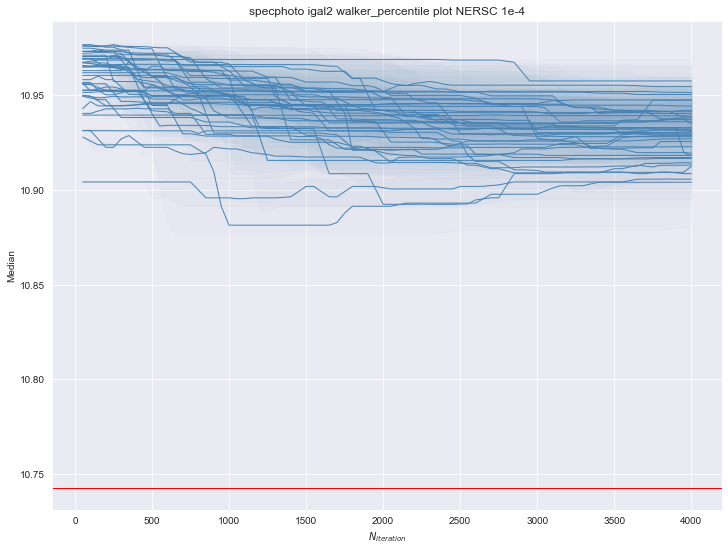

In [72]:
num_stat_prob = i2e_4.walker_perc_plot(2, 'specphoto', 50, cl = False, flag = 'NERSC 1e-4')
print(num_stat_prob)

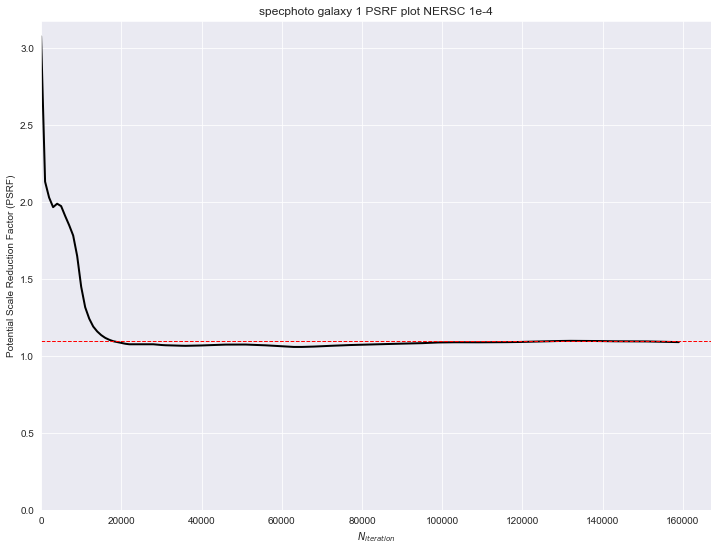

In [70]:
i2e_4.PSRF_plot('specphoto', 1000, flag = 'NERSC 1e-4')

16


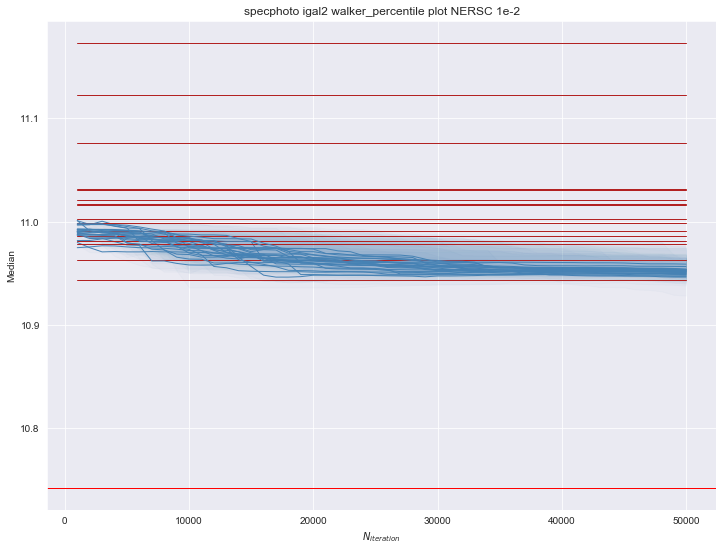

In [60]:
num_stat_prob =  i2_prob.walker_perc_plot(2,'specphoto', 1000, cl = False, flag = 'NERSC 1e-2')
plt.savefig('stat_nersc_1e-2.pdf', format = 'pdf')
print(num_stat_prob)

8


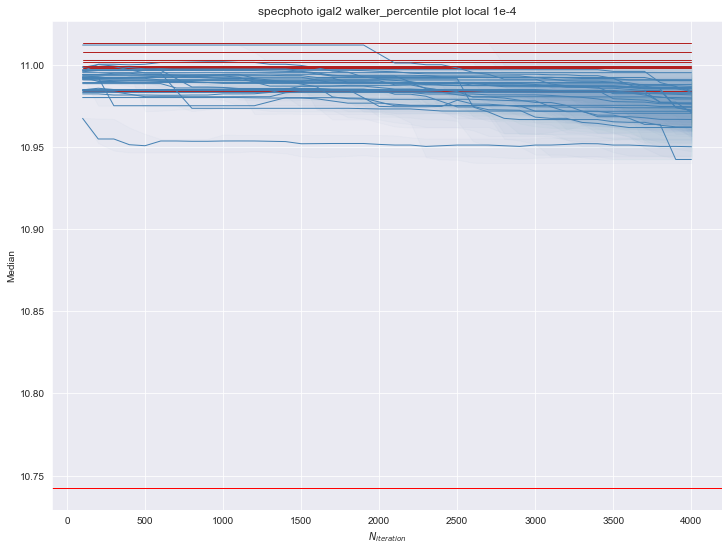

In [61]:
num_stat = i2.walker_perc_plot(2,'specphoto',100,cl = False, flag = 'local 1e-4')
plt.savefig('nersc_igal2_walker_3.pdf')
print(num_stat)

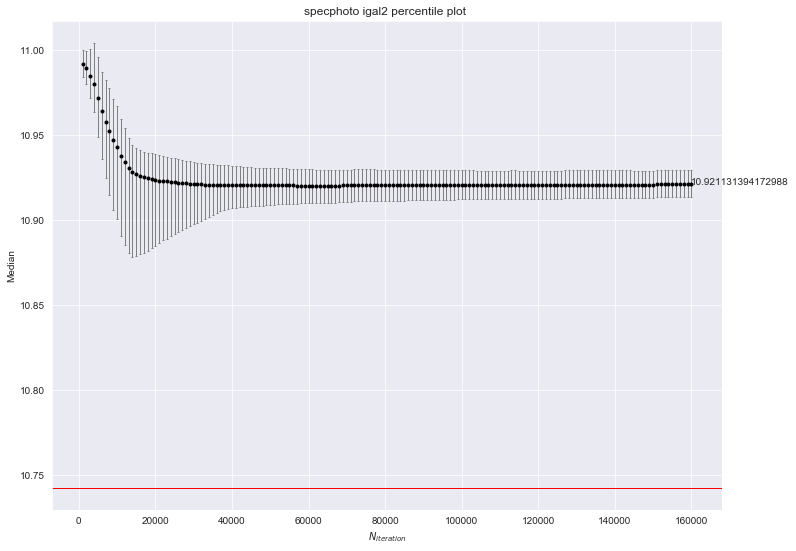

In [62]:
i2.avg_perc_plot(2, 'specphoto', 1000, flag = '')
plt.savefig('nersc_igal2_perc_3.pdf')

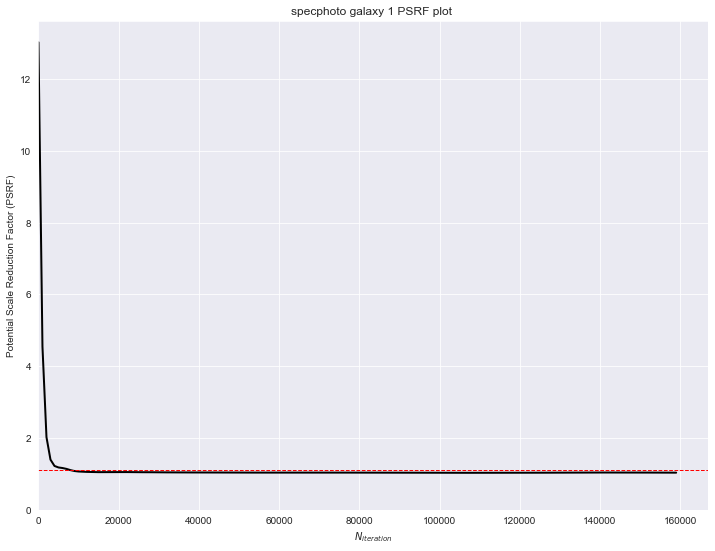

In [63]:
i2.PSRF_plot('specphoto')